## Machine Learning Classification Model

### Cycling Predictor

### Aim
I don't want to say I'm a fair weather cyclist but my days of riding through heavy rain or having to go up against brutal headwinds are reaching an end. To help plan my rides better, I’ll be using weather data from Australia’s Bureau of Meteorology alongside my personal cycling data from Strava, to train a machine learning model. The goal is to have this model predict the likelihood of going cycling on any given day based on the upcoming weather forecast, helping me choose the best days to ride.


### Data Cleaning

In [1]:
# load libraries
# for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for machine learning
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# load data
weather = pd.read_csv('Weather Data.csv')
cycling = pd.read_csv('Cycling Data.csv')

#### Weather Data

In [3]:
# view weather data
weather.head()

,"Daily Weather Observations for Melbourne, Victoria for July 2023 - August 2024",Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,NaN,2023-07-1,9.7,13.5,0.4,2.6,4.2,SSW,33.0,12:32,...,1,W,11,1023.2,11.3,89,6.0,SW,9,1025.8
1,NaN,2023-07-2,9.6,12.8,0.6,0.0,0.2,S,17.0,11:02,...,6,SW,6,1033.9,11.9,83,7.0,SSW,9,1032.7
2,NaN,2023-07-3,8.2,14.5,0.4,1.2,0.2,N,20.0,14:58,...,7,NNE,7,1030.4,14.1,64,7.0,N,13,1024.8
3,NaN,2023-07-4,8.3,13.6,0.0,0.8,0.0,NE,15.0,07:48,...,7,NNE,9,1017.9,13.4,77,8.0,NE,9,1012.7
4,NaN,2023-07-5,10.8,14.7,2.4,0.0,3.1,NNW,31.0,14:36,...,7,NW,4,1012.2,13.7,56,5.0,NNW,13,1011.2


In [4]:
# drop columns that are not included in the weather forecast and therefore don't influence my decision to go riding
weather = weather.drop(columns=['Daily Weather Observations for Melbourne, Victoria for July 2023 - August 2024', 
                               'Evaporation (mm)', 'Direction of maximum wind gust ', 'Time of maximum wind gust', 
                               '9am Temperature (°C)', '9am relative humidity (%)', '9am cloud amount (oktas)', 
                               '9am wind direction', '9am MSL pressure (hPa)', '3pm Temperature (°C)', 
                                '3pm relative humidity (%)', '3pm wind direction', '3pm cloud amount (oktas)', '3pm MSL pressure (hPa)'])

In [5]:
# convert data types to their correct type
weather = weather.convert_dtypes(infer_objects=True)
weather.dtypes

Date                                  string
Minimum temperature (°C)             Float64
Maximum temperature (°C)             Float64
Rainfall (mm)                        Float64
Sunshine (hours)                     Float64
Speed of maximum wind gust (km/h)      Int64
9am wind speed (km/h)                 string
3pm wind speed (km/h)                 string
dtype: object

The two wind speed columns could not be changed to integers and appear as strings due to the presence of textual data. After reviewing the original data source, it can be seen that some entries have the word Calm listed instead of the actual speed. Where 'Calm' appears, I will replace it with the wind speed from the other reading on the same day.

In [6]:
# update missing wind speed with value from second wind speed column.
weather['9am wind speed (km/h)'] = np.where(weather['9am wind speed (km/h)'] == 'Calm', weather['3pm wind speed (km/h)'], weather['9am wind speed (km/h)'])
weather['3pm wind speed (km/h)'] = np.where(weather['3pm wind speed (km/h)'] == 'Calm', weather['9am wind speed (km/h)'], weather['3pm wind speed (km/h)'])
# convert data types
weather['9am wind speed (km/h)'] = pd.to_numeric(weather['9am wind speed (km/h)'], errors='coerce')
weather['3pm wind speed (km/h)'] = pd.to_numeric(weather['3pm wind speed (km/h)'], errors='coerce')
# convert to datetime format
weather['Date'] = pd.to_datetime(weather['Date'])
weather.dtypes

Date                                 datetime64[ns]
Minimum temperature (°C)                    Float64
Maximum temperature (°C)                    Float64
Rainfall (mm)                               Float64
Sunshine (hours)                            Float64
Speed of maximum wind gust (km/h)             Int64
9am wind speed (km/h)                         int64
3pm wind speed (km/h)                         int64
dtype: object

In [7]:
# check for missing data
weather[pd.isnull(weather).any(axis=1)]

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h)
39,2023-08-09,5.5,18.4,0.2,8.5,<NA>,13,24
241,2024-02-27,12.9,27.4,0.0,10.9,<NA>,7,11
342,2024-06-07,9.3,16.0,0.0,1.7,<NA>,7,13


The missing data in the maximum wind gust column will be imputed once the two data sets have been merged and the wind speed columns have been combined into one based on the corresponding activity time from the cycling dataset.

#### Cycling Data

In [8]:
# view all columns in the cycling DataFrame
print(cycling.columns)
# drop unnecessary columns
cycling = cycling[['Activity Date', 'Moving Time', 'Distance.1', 'Average Speed', 'Elevation Gain',
                   'Average Temperature']]

Index(['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type',
       'Activity Description', 'Elapsed Time', 'Distance', 'Max Heart Rate',
       'Relative Effort', 'Commute', 'Activity Private Note', 'Activity Gear',
       'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1',
       'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed',
       'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High',
       'Max Grade', 'Average Grade', 'Average Positive Grade',
       'Average Negative Grade', 'Max Cadence', 'Average Cadence',
       'Max Heart Rate.1', 'Average Heart Rate', 'Max Watts', 'Average Watts',
       'Calories', 'Max Temperature', 'Average Temperature',
       'Relative Effort.1', 'Total Work', 'Number of Runs', 'Uphill Time',
       'Downhill Time', 'Other Time', 'Perceived Exertion', 'Type',
       'Start Time', 'Weighted Average Power', 'Power Count',
       'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1',
    

In [9]:
# check for missing data
cycling[pd.isnull(cycling).any(axis=1)]

,Activity Date,Moving Time,Distance.1,Average Speed,Elevation Gain,Average Temperature


In [10]:
# view cycling data
cycling.head()

,Activity Date,Moving Time,Distance.1,Average Speed,Elevation Gain,Average Temperature
0,"5 Jul 2023, 06:40:41",3704.0,30432.550781,8.216131,30.0,11.0
1,"10 Jul 2023, 06:55:26",3748.0,30410.199219,8.113714,70.0,13.0
2,"12 Jul 2023, 07:39:00",4412.0,35607.578125,8.070621,40.0,13.0
3,"19 Jul 2023, 07:11:12",4264.0,35598.378906,8.348588,40.0,9.0
4,"21 Jul 2023, 01:48:48",3636.0,31191.509766,8.578523,59.0,13.0


Having reviewed this data, I can see that all of the times in the Activity Date column are ten hours behind (indicating they are in GMT instead of AEST). I will be needing this information later to determine the correct wind speed and so must update this information.

In [11]:
# convert Activity Date into a datetime object
cycling['Activity Date'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S')
# add ten hours to each value
cycling['Activity Date'] = cycling['Activity Date'] + pd.to_timedelta(10, unit='h')
# split Activity Date column into separate Date and Time columns with Date matching the formatting from weather dataframe.
cycling['Date'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S').dt.strftime('%Y-%m-%d')
cycling['Time'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S').dt.strftime('%H:%M:%S')
# drop original Activity Date column
cycling = cycling.drop(columns=['Activity Date'])
# Move Date and Time columns to front
cycling.insert(0, 'Date', cycling.pop('Date'))
cycling.insert(1, 'Time', cycling.pop('Time'))
# update data types
cycling['Date'] = pd.to_datetime(cycling['Date'])
cycling['Time'] = pd.to_datetime(cycling['Time'])
# remove date from Time column
cycling['Time'] = pd.to_datetime(cycling['Time'], format='%d %b %Y, %H:%M:%S').dt.strftime('%H:%M:%S')

The data is in seconds and meters and needs to be updated to be in minutes and kilometers.

In [12]:
# update data values
# convert Moving Time to minutes
cycling['Moving Time'] = (cycling['Moving Time'] / 60).round(2)
# convert Distance to kilometers
cycling['Distance.1'] = (cycling['Distance.1'] / 1000).round(2)
# convert Average Speed to kmph
cycling['Average Speed'] = (cycling['Average Speed'] * 3.6).round(2)

In [13]:
# update column names
cycling.rename(columns={'Moving Time': 'Moving Time (mins)', 'Distance.1': 'Distance (km)', 'Average Speed': 'Average Speed (km/h)', 'Elevation Gain': 'Elevation Gain (m)', 'Average Temperature': 'Average Temperature during ride'}, inplace=True)

Both datasets have now been cleaned and can be merged into a single data source based on their shared Date columns.

In [14]:
cycling.head()

,Date,Time,Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
0,2023-07-05,16:40:41,61.73,30.43,29.58,30.0,11.0
1,2023-07-10,16:55:26,62.47,30.41,29.21,70.0,13.0
2,2023-07-12,17:39:00,73.53,35.61,29.05,40.0,13.0
3,2023-07-19,17:11:12,71.07,35.60,30.05,40.0,9.0
4,2023-07-21,11:48:48,60.60,31.19,30.88,59.0,13.0


In [15]:
# merge data sets based on Date column
combineddf = weather.merge(cycling, how='left', on='Date')

## Data preparation

Now that the two datasets have been cleaned, I will prepare the data to be used in the machine learning task. This involves:
1. Creating a boolean column that displays a 0 on dates where no ride has occurred and a 1 against dates where a ride occured.

2. Creating a new wind column that selects the 9am or 3pm value based on time of ride. After creating this, the Time column is no longer required.

3. Creating additional feature columns that compare the values for the current day against the preceding 4 day average. This is important as it's often not the explicit weather that determines whether I go cycling, or else I just wouldn't ride during winter, instead I'm often choosing the nicer days of each week.

In [16]:
#create a boolean Ride YN (1/0) column
# initialise column with zeros
combineddf.insert(8, 'Cycling Activity (Y/N)', 0)
# edit value to equal 1 where cycling data exists
combineddf.loc[combineddf['Moving Time (mins)'].notna(), 'Cycling Activity (Y/N)'] = 1

The single wind speed column will select its value based on the Time column. If the Time value is before midday, the 9am wind speed will be used. If the time value is after midday, the 3pm wind speed will be used. If no ride took place on that day, that day's average value will be used.

In [17]:
# convert Time column to datetime data type keeping just time portion
combineddf['Time'] = pd.to_datetime(combineddf['Time'], format='%H:%M:%S').dt.time

# create single wind speed column
combineddf['Wind speed (km/h)'] = combineddf.apply(
    lambda row: np.nanmean([row['9am wind speed (km/h)'], row['3pm wind speed (km/h)']]) if pd.isna(row['Time'])
    else row['9am wind speed (km/h)'] if row['Time'].hour < 12
    else row['3pm wind speed (km/h)'],
    axis=1)

In [18]:
# drop the Time, 9am and 3pm columns.
combineddf = combineddf.drop(columns=['Time', '9am wind speed (km/h)', '3pm wind speed (km/h)'])
# Move the new Wind Speed column to be with the weather data.
combineddf.insert(6, 'Wind speed (km/h)', combineddf.pop('Wind speed (km/h)'))

I'll next create four additional feature columns comparing min temp, max temp, rainfall and wind speed against the average values of the previous 4 days. This enables the current weather to be compared to that of the short term average, helping to factor in the changing weather throughout the year. Negative figures indicate the current day's value is below the short term average and positive figures indicate that the current day's value is above the short term average.

In [19]:
# create columns to view how that days weather differed from the previous 4 day average

# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Minimum temperature (°C)'].shift(1)
# calculate 4-day rolling average Min Temp
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Min Temp and the 4-day rolling average
combineddf.insert(2, '4DAvg Difference (Min Temp)', combineddf['Minimum temperature (°C)'] - combineddf['4_day_avg'])


# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Maximum temperature (°C)'].shift(1)
# calculate 4-day rolling average Max Temp
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Max Temp and the 5-day rolling average
combineddf.insert(4, '4DAvg Difference (Max Temp)', combineddf['Maximum temperature (°C)'] - combineddf['4_day_avg'])


# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Rainfall (mm)'].shift(1)
# calculate 4-day rolling average Rainfall
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Rainfall and the 4-day rolling average
combineddf.insert(6, '4DAvg Difference (Rainfall)', combineddf['Rainfall (mm)'] - combineddf['4_day_avg'])


# Shift the column by 1 day to exclude the current day from the rolling window
combineddf['Shifted Col'] = combineddf['Wind speed (km/h)'].shift(1)
# calculate 4-day rolling average Wind Speed
combineddf['4_day_avg'] = combineddf['Shifted Col'].rolling(window=4).mean()
# calculate the difference between Rainfall and the 4-day rolling average
combineddf.insert(10, '4DAvg Difference (Wind Speed)', combineddf['Wind speed (km/h)'] - combineddf['4_day_avg'])

# drop columns
combineddf = combineddf.drop(columns=['Shifted Col', '4_day_avg'])

The first four rows of data have missing data in their 4DAvg columns due to their being no earlier data available to calculate these values. The simplest solution to resolve this is to drop these rows.

In [20]:
# drop the 4 rows with missing values in the 4DAvg columns
combineddf.drop(index=range(0,4), axis=0, inplace=True)
# reset the index
combineddf = combineddf.reset_index(drop=True)

The missing Max Wind Gust values identified when cleaning the Weather data can now be filled with the average Max Wind Gust for their corresponding wind speeds.

In [21]:
# convert wind gust column to float
combineddf['Speed of maximum wind gust (km/h)'] = combineddf['Speed of maximum wind gust (km/h)'].astype('float64')

# fill missing max gust values based on average of corresponding wind speed values
avg_gust = combineddf.loc[combineddf['Wind speed (km/h)'] == 18.5, 'Speed of maximum wind gust (km/h)'].mean()
combineddf.loc[(combineddf['Wind speed (km/h)'] == 18.5) & (combineddf['Speed of maximum wind gust (km/h)'].isna()), 
               'Speed of maximum wind gust (km/h)'] = avg_gust


avg_gust = combineddf.loc[combineddf['Wind speed (km/h)'] == 11.0, 'Speed of maximum wind gust (km/h)'].mean()
combineddf.loc[(combineddf['Wind speed (km/h)'] == 11.0) & (combineddf['Speed of maximum wind gust (km/h)'].isna()), 
               'Speed of maximum wind gust (km/h)'] = avg_gust

avg_gust = combineddf.loc[combineddf['Wind speed (km/h)'] == 10.0, 'Speed of maximum wind gust (km/h)'].mean()
combineddf.loc[(combineddf['Wind speed (km/h)'] == 10.0) & (combineddf['Speed of maximum wind gust (km/h)'].isna()), 
               'Speed of maximum wind gust (km/h)'] = avg_gust

### Initial Analysis

Before developing my model, I'll first complete a brief exploratory analysis of the data to uncover trends, patterns, and relationships that exist within it. 

In [22]:
# number of rides in the 6 months of data
a = (combineddf['Cycling Activity (Y/N)'] == 1).sum()
print('Number of rides during the period of data collection:', a)

# average number of rides per week
# extract the week number using the date column and count
unique_weeks = combineddf['Date'].dt.isocalendar().week.nunique()

print('Average number of rides per week:', round(a/unique_weeks, 2))

Number of rides during the period of data collection: 101
Average number of rides per week: 1.94


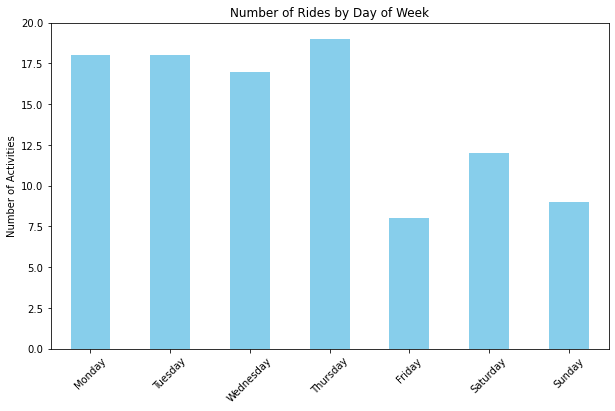

In [23]:
# create weekday column
combineddf.insert(1, "Weekday", combineddf['Date'].dt.day_name())

# count number of activities that fall on each day
activity_count = combineddf[combineddf['Cycling Activity (Y/N)'] == 1]['Weekday'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

# plot number of rides by day of week
plt.figure(figsize=(10, 6))
activity_count.plot(kind='bar', color='skyblue')
plt.ylim([0, 20])
plt.title('Number of Rides by Day of Week')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.show()





The below output displays the number of positive and negative values in each of the columns that compare the day's value to the 4-day average on the days I went cycling.

In [24]:
# Proportion of positive and negative 4 day average values when I've gone for a ride.
# Filter the DataFrame for only where Ive gone riding
filtered_df = combineddf[combineddf['Cycling Activity (Y/N)'] == 1]

# Count the number of positive and negative values in the Min Temp column
positive_count = (filtered_df['4DAvg Difference (Min Temp)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Min Temp)'] < 0).sum()

print("Min Temp")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Max Temp column
positive_count = (filtered_df['4DAvg Difference (Max Temp)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Max Temp)'] < 0).sum()

print("Max Temp")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Rainfall column
positive_count = (filtered_df['4DAvg Difference (Rainfall)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Rainfall)'] < 0).sum()

print("Rainfall")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Wind Speed column
positive_count = (filtered_df['4DAvg Difference (Wind Speed)'] > 0).sum()
negative_count = (filtered_df['4DAvg Difference (Wind Speed)'] < 0).sum()

print("Wind Speed")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")


Min Temp
Number of positive values: 43
Number of negative values: 58
Max Temp
Number of positive values: 51
Number of negative values: 50
Rainfall
Number of positive values: 25
Number of negative values: 50
Wind Speed
Number of positive values: 46
Number of negative values: 53


This information shows that on the days I went riding there was more often a lower negative temperature, it was much less rainy and slightly less windy.

### Machine Learning

I will now develop the machine learning model that will be used to predict whether I will go cycling based on the weather forecast. Various algorithms, including logistic regression, random forests, and XGBoost will be trialed. I will continue the process of feature engineering, using One Hot Encoding to extract the 'Weekday' categories, scale the data and remove irrelevant attributes to reduce noise within the dataset. The performance of each model will be assessed using accuracy, precision, recall, f1 score and the confusion matrix metrics.

In [25]:
# encode the Weekday categorical data using One Hot Encoder

# initialise encoder
encoder = OneHotEncoder(sparse=False)

# fit and transform the data
encoded_array = encoder.fit_transform(combineddf[['Weekday']])

# create new dataframe with the encoded data
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Weekday']))

# merge with original "combineddf" dataframe
combineddf = pd.concat([combineddf, encoded_df], axis=1)

In [26]:
# drop irrelevant columns to reduce complexity and noise

# date, weekday and cycling details columns are no longer needed
combineddf = combineddf.drop(columns=['Date', 'Weekday', 'Moving Time (mins)', 'Distance (km)', 
                                      'Average Speed (km/h)', 'Elevation Gain (m)', 
                                      'Average Temperature during ride'])

#Check that number of rows is at least 5 x the number of features
len(combineddf)

421

#### Logistic Regression

In [27]:
# move binary cycling activity indicator column to start of dataframe for clarity
combineddf.insert(0, 'Cycling Activity (Y/N)', combineddf.pop('Cycling Activity (Y/N)'))
combineddf.head()

,Cycling Activity (Y/N),Minimum temperature (°C),4DAvg Difference (Min Temp),Maximum temperature (°C),4DAvg Difference (Max Temp),Rainfall (mm),4DAvg Difference (Rainfall),Sunshine (hours),Speed of maximum wind gust (km/h),Wind speed (km/h),4DAvg Difference (Wind Speed),Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,1,10.8,1.85,14.7,1.1,2.4,2.05,3.1,31.0,13.0,3.875,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,10.0,0.775,15.2,1.3,0.0,-0.85,7.3,50.0,19.5,9.625,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,9.9,0.575,15.5,1.0,1.0,0.3,6.8,39.0,14.0,1.125,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,10.5,0.75,14.9,0.15,1.2,0.35,6.8,52.0,20.5,6.625,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,10.9,0.6,16.9,1.825,0.2,-0.95,3.5,39.0,10.0,-6.750,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
# assign features and target
X = pd.concat([combineddf.iloc[:, 1:18]], axis=1)
y = combineddf['Cycling Activity (Y/N)']

In [29]:
# split data into training and testing with stratified sampling to preserve classification weightings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)

In [30]:
# standardise data to avoid convergence warning
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# initialise and train regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

In [32]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.7529411764705882
Confusion Matrix:
[[62  3]
 [18  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        65
           1       0.40      0.10      0.16        20

    accuracy                           0.75        85
   macro avg       0.59      0.53      0.51        85
weighted avg       0.69      0.75      0.69        85



On face value, this model is 75% accurate in predicting whether I would go cycling on a particular day. However the results show that it is much better at predicting when I won't go cycling than when I will, correctly predicting 62 of the 65 days that I didn't go cycling but incorrectly predicting that I wouldn't go cycling on 18 days that I did. An f1 score of 0.16 confirms the model's difficulty in predicting days when I would go riding and is likely due to the class imbalance in the dataset.

Of course there are many more factors that go into whether I go riding than just the weather including work deadlines, injuries, holidays, assignments and illness. Using my calendar I will remove dates where I know there were other reasons that caused me not to go riding and will run the model again.

In [33]:
# re-add Date column
combineddf.insert(0, 'Date', pd.date_range(start='2023-07-05', periods=len(combineddf), freq='D'))

In [34]:
# dates to remove
remove_dates = ['2023-07-09', '2023-07-14', '2023-07-15', '2023-07-16', '2023-07-17', '2023-07-28', 
                     '2023-07-29', '2023-07-30', '2023-08-26', '2023-09-04', '2023-09-05', '2023-09-06', 
                    '2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10', '2023-09-16', '2023-09-17', 
                    '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', 
                    '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', 
                    '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', 
                    '2023-11-06', '2023-11-07', '2023-11-18', '2023-11-19', '2023-12-25', '2023-12-26', 
                    '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31', '2024-01-01', 
                     '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', 
                     '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-19', 
                     '2024-01-20', '2024-01-21', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15', 
                     '2024-02-16', '2024-02-17', '2024-02-18', '2024-03-09', '2024-03-10', '2024-03-11', 
                     '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-23', '2024-03-27', 
                    '2024-03-28', '2024-03-29', '2024-03-30', '2024-03-31', '2024-04-17', '2024-04-18', 
                     '2024-04-19', '2024-04-20', '2024-04-21', '2024-05-20', '2024-05-21', '2024-05-22', 
                    '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', 
                    '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03', 
                     '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09', 
                     '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15', 
                     '2024-07-16', '2024-07-17', '2024-07-18', '2024-07-19', '2024-08-04', '2024-08-05', 
                     '2024-08-06']

# convert to datetime
remove_dates = pd.to_datetime(remove_dates)

# remove dates
combineddf = combineddf[~combineddf['Date'].isin(remove_dates)]
# drop Date column
combineddf = combineddf.drop(columns=['Date'])
combineddf = combineddf.reset_index(drop=True)

Train and test the linear regression model on the refined dataset

In [35]:
# train regression model
# assign features and target
X = pd.concat([combineddf.iloc[:, 1:18]], axis=1)
y = combineddf['Cycling Activity (Y/N)']
# split data into training and testing with stratified sampling to preserve classification weightings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
# standardise data to avoid convergence warning
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# initialise and train regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

In [36]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.6666666666666666
Confusion Matrix:
[[36  5]
 [15  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.78        41
           1       0.44      0.21      0.29        19

    accuracy                           0.67        60
   macro avg       0.58      0.54      0.53        60
weighted avg       0.62      0.67      0.63        60



Model accuracy appears to have slightly dropped but the results have actually improved in terms of predicting when I will go cycling. It is still biased towards predicting days that I won't go riding but this indicates that balancing the classes would continue to improve accuracy.

I will now assess the performance of the RandomForestClassifier and XGBoost algorithms before developing the final model.

#### Random Forest Classifier

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)

# Initialize the RandomForest model
randomforest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
randomforest_model.fit(X_train, y_train)

# Predict on the test data
y_pred = randomforest_model.predict(X_test)

In [38]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.6666666666666666
Confusion Matrix:
[[37  4]
 [16  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79        41
           1       0.43      0.16      0.23        19

    accuracy                           0.67        60
   macro avg       0.56      0.53      0.51        60
weighted avg       0.61      0.67      0.61        60



#### XGBoost

In [39]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Initialize the XGBoost model
xgboost_model = XGBClassifier(n_estimators=100, random_state=42)

# Train the model
xgboost_model.fit(X_train, y_train)

# Predict on the test data
y_pred = xgboost_model.predict(X_test)

In [40]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.6166666666666667
Confusion Matrix:
[[29  5]
 [18  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.85      0.72        34
           1       0.62      0.31      0.41        26

    accuracy                           0.62        60
   macro avg       0.62      0.58      0.56        60
weighted avg       0.62      0.62      0.58        60



Since my main interest is in predicting the days that I will go cycling, the XGBoost model is our preferred algorithm due to its high precision and recall for class 1.

#### Hyperparameter Tuning
Moving ahead with the XGBoost algorithm, I will tune the hyperparameters before defining and testing the final model. Due to computational limitations, I am only conducting a small number of cross validation folds. This will assist me in finding the optimal parameters for my model.

In [41]:
# Set up parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1]
}

# Initialize the XGBClassifier
xgboost_model = XGBClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(xgboost_model, param_grid, cv=2, scoring='accuracy', verbose=1)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Output the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Use the best estimator for predictions
best_xgboost_model = grid_search.best_estimator_
y_pred_best = best_xgboost_model.predict(X_test)

Fitting 2 folds for each of 4374 candidates, totalling 8748 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.01, 'subsample': 1.0}


### Results

Through trialling a number of models we've found that the XGBoostClassifier works best for our dataset. After tuning the model's hyperparameters, I receive the following results:

In [42]:
# Evaluate the model as before
accuracy = accuracy_score(y_test, best_xgboost_model.predict(X_test))
print(f'Accuracy: {accuracy}')
cm = confusion_matrix(y_test, best_xgboost_model.predict(X_test))
print('Confusion Matrix:')
print(cm)
report = classification_report(y_test, best_xgboost_model.predict(X_test))
print('Classification Report:')
print(report)

Accuracy: 0.65
Confusion Matrix:
[[31  3]
 [18  8]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.91      0.75        34
           1       0.73      0.31      0.43        26

    accuracy                           0.65        60
   macro avg       0.68      0.61      0.59        60
weighted avg       0.67      0.65      0.61        60



In comparison to the original XGBoost model, this tuned version has a higher accuracy, precision and f1 score and an identical recall for days when I went cycling. Having said this, trialing a larger set of hyperparameters would assist in increasing it's abilities further.

Below, I load the weather forecast for August 26 to September 1, a warmer week in Melbourne, but one with high winds and some rain. The model has been configured to display its output as a % probability of me going riding on that day.

In [43]:
# load new forecast
unseen_forecast = pd.read_csv('26Aug1Sep.csv')

# Predict the probability of going cycling based on the upcoming weather forecast
unseen_probabilities = best_xgboost_model.predict_proba(unseen_forecast)[:, 1]

# Convert to percentages
percentages = unseen_probabilities * 100

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(len(unseen_forecast)):
    weekday = weekdays[i % 7]  # Use modulo to loop through the weekdays
    print(f'Probability of going cycling on {weekday}: {percentages[i]:.2f}%\n')

Probability of going cycling on Monday: 72.62%

Probability of going cycling on Tuesday: 0.54%

Probability of going cycling on Wednesday: 17.41%

Probability of going cycling on Thursday: 20.37%

Probability of going cycling on Friday: 2.56%

Probability of going cycling on Saturday: 10.72%

Probability of going cycling on Sunday: 14.00%

